# VGG

This notebook uses model "VGG16" to conduct regression of images.

In [1]:
import h5py
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models

## Step 1 - Config

First set the hyperparameters and other configurations.

In [ ]:
# Dataset and model path
DATASET_PATH = "./datasets/Ra_128_indexed.h5"
DATASET_FAKE_PATH = "./datasets/CcGAN_SAGAN_dim_128_128_batchSizeG_64_batchSizeD_64_lrG_1e-04_lrD_1e-04_nIters_30000_nDsteps_4_soft_0.047_108.739_loss_hinge_seed_42_in_generate.h5"
MODEL_DIR = "./models"
OUTPUT_DIR = "./outputs"
# Env
SEED = 42
# Dataset
MIN_LABEL = 1.3
MAX_LABEL = 5.2
# Hyperparameters
NUM_EPOCHS = 3
LR = 1e-3
LR_WEIGHT_DECAY = 1e-4
TEST_SIZE = 0.2
BATCH_SIZE_TRAIN = 256
BATCH_SIZE_VAL = 10

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Path
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR, exist_ok=True)
    print(f"Make new directory {MODEL_DIR}")
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    print(f"Make new directory {OUTPUT_DIR}")
MODEL_PATH = f"{MODEL_DIR}/VGG16_epoch_{NUM_EPOCHS}_batch_size_{BATCH_SIZE_TRAIN}_lr_{LR:.0e}_seed_{SEED}.pth"
OUTPUT_PATH = f"{OUTPUT_DIR}/VGG16_epoch_{NUM_EPOCHS}_batch_size_{BATCH_SIZE_TRAIN}_lr_{LR:.0e}_seed_{SEED}.csv"

Device: cuda


Then load the pretrained model from `torchvision`.

In [3]:
# Pretrained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Change the last layer to fit the regression task
vgg16.classifier[-1] = nn.Linear(in_features=4096, out_features=1)

# Choose to freeze the layers or not
for param in vgg16.features.parameters():
    param.requires_grad = False

# Move to the appropriate device
vgg16 = vgg16.to(device)

/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Step 2 - Load data

In this step we load the images and process them, the goal is to get `train_loader` and `val_loader` for training. After this step we will get:

1. `images_train` and `images_val` (4 dim tensor)
2. `labels_train` and `labels_val` (1 dim tensor)
3. `train_dataset` and `val_dataset` (dataset)
4. `train_loader` and `val_loader` (dataloader)

First we load the images (`images`) and labels (`labels`).

In [ ]:
# Load datasets
with h5py.File(DATASET_PATH, "r") as f:
    images = f["images"][:].astype(float)
    labels = f["labels"][:].astype(float)
N_all = len(images)
print("Images and labels loaded.")
print(f"Images Shape: {images.shape}")
print(f"Labels Shape: {labels.shape}")
print("")

# Load fake datasets
with h5py.File(DATASET_FAKE_PATH, "r") as f:
    images_fake = f["images"][:].astype(float)
    labels_fake = f["labels"][:].astype(float)
N_fake_all = len(images_fake)
print("Fake images and labels loaded.")
print(f"Fake Images Shape: {images_fake.shape}")
print(f"Fake Labels Shape: {labels_fake.shape}")

# Selection
indx = np.where((labels >= MIN_LABEL) * (labels < MAX_LABEL) == True)[0]
labels = labels[indx]
images = images[indx]
print(f"Select indexes by MIN_LABEL = {MIN_LABEL} and MAX_LABEL = {MAX_LABEL}")
print(f"Images Shape: {images.shape}")
print(f"Labels Shape: {labels.shape}")
print("")

# Selection fake
indx_fake = np.where((labels_fake >= MIN_LABEL) * (labels_fake < MAX_LABEL) == True)[0]
labels_fake = labels_fake[indx_fake]
images_fake = images_fake[indx_fake]
print(f"Select fake indexes by MIN_LABEL = {MIN_LABEL} and MAX_LABEL = {MAX_LABEL}")
print(f"Fake Images Shape: {images_fake.shape}")
print(f"Fake Labels Shape: {labels_fake.shape}")
print("")

# To tensor
images = torch.from_numpy(images).permute(0, 3, 1, 2)
labels = torch.from_numpy(labels)
print("Transform `images` and `labels` to tensors.")
print(f"Images Shape: {images.shape}")
print(f"Labels Shape: {labels.shape}")

# Fake to tensor
images_fake = torch.from_numpy(images_fake).permute(0, 3, 1, 2)
labels_fake = torch.from_numpy(labels_fake)
print("Transform `images_fake` and `labels_fake` to tensors.")
print(f"Fake Images Shape: {images_fake.shape}")
print(f"Fake Labels Shape: {labels_fake.shape}")

Images and labels loaded.
Images Shape: (9192, 128, 128, 3)
Labels Shape: (9192,)



Select indexes by MIN_LABEL = 1.3 and MAX_LABEL = 5.2
Images Shape: (9192, 128, 128, 3)
Labels Shape: (9192,)

Transform `images` and `labels` to tensors.
Images Shape: torch.Size([9192, 3, 128, 128])
Labels Shape: torch.Size([9192])


Then use `train_test_split` function to get data for training and validation, and add all fake images and labels to the training set.

In [ ]:
# Train-test split
images_train, images_val, labels_train, labels_val = train_test_split(
    images, labels, test_size=TEST_SIZE, random_state=SEED
)

# Add fake images and labels
images_train = torch.cat((images_train, images_fake), dim=0)
labels_train = torch.cat((labels_train, labels_fake), dim=0)

Implement images standardization and labels normalization.

In [6]:
# Image standardization
mean = images_train.mean(dim=[0, 2, 3], keepdim=True)
std = images_train.std(dim=[0, 2, 3], keepdim=True)
print(f"Mean of `images_train`: {mean}")
print(f"Std of `images_train`: {std}")
images_train = (images_train - mean) / std
images_val = (images_val - mean) / std

# Label normalization
labels_train = (labels_train - MIN_LABEL) / (MAX_LABEL - MIN_LABEL)
labels_val = (labels_val - MIN_LABEL) / (MAX_LABEL - MIN_LABEL)

print(f"Train test split with test size {TEST_SIZE}.")
print(f"Images (train) Shape: {images_train.shape}")
print(f"Images (val) Shape: {images_val.shape}")
print(f"Labels (train) Shape: {labels_train.shape}")
print(f"Labels (val) Shape: {labels_val.shape}")

Mean of `images_train`: tensor([[[[ 13.5371]],

         [[ 17.8462]],

         [[112.1119]]]], dtype=torch.float64)
Std of `images_train`: tensor([[[[18.5847]],

         [[20.2589]],

         [[41.6000]]]], dtype=torch.float64)


Train test split with test size 0.2.
Images (train) Shape: torch.Size([7353, 3, 128, 128])
Images (val) Shape: torch.Size([1839, 3, 128, 128])
Labels (train) Shape: torch.Size([7353])
Labels (val) Shape: torch.Size([1839])


Next, we should transform the data to tensors, combine `images` and `labels` to datasets and get dataloaders according to `BATCH_SIZE`.

In [7]:
# Change to tensor
images_train_tensor = torch.tensor(images_train, dtype=torch.float32)
images_val_tensor = torch.tensor(images_val, dtype=torch.float32)
labels_train_tensor = torch.tensor(labels_train, dtype=torch.float32).view(-1, 1)
labels_val_tensor = torch.tensor(labels_val, dtype=torch.float32).view(-1, 1)
print(f"Shape of `images_train_tensor`: {images_train_tensor.shape}")
print(f"Shape of `labels_train_tensor`: {labels_train_tensor.shape}")
print(f"Shape of `images_val_tensor`: {images_val_tensor.shape}")
print(f"Shape of `labels_val_tensor`: {labels_val_tensor.shape}")

# Tensor's dataset
train_dataset = TensorDataset(images_train_tensor, labels_train_tensor)
val_dataset = TensorDataset(images_val_tensor, labels_val_tensor)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE_VAL)

/tmp/ipykernel_141443/1722485521.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images_train_tensor = torch.tensor(images_train, dtype=torch.float32)


Shape of `images_train_tensor`: torch.Size([7353, 3, 128, 128])
Shape of `labels_train_tensor`: torch.Size([7353, 1])
Shape of `images_val_tensor`: torch.Size([1839, 3, 128, 128])
Shape of `labels_val_tensor`: torch.Size([1839, 1])


/tmp/ipykernel_141443/1722485521.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images_val_tensor = torch.tensor(images_val, dtype=torch.float32)
/tmp/ipykernel_141443/1722485521.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_train_tensor = torch.tensor(labels_train, dtype=torch.float32).view(-1, 1)
/tmp/ipykernel_141443/1722485521.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_val_tensor = torch.tensor(labels_val, dtype=torch.float32).view(-1, 1)


## Step 3 - Train

Start training for `epoch` loops, record the training losses and validation losses.

In [8]:
# Criterion and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(
    vgg16.classifier.parameters(), lr=LR, weight_decay=LR_WEIGHT_DECAY
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=5
)

# Record the loss values
train_loss_list = []
val_loss_list = []

# Loop by epoch
for epoch in range(NUM_EPOCHS):

    # Train
    vgg16.train()
    train_loss = 0.0
    train_size = 0
    for batch_images, batch_labels in train_loader:
        # Load data
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)
        # Pass loss value
        outputs = vgg16(batch_images)
        loss = criterion(outputs, batch_labels)
        # Back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Add to the total loss
        batch_size = batch_images.size(0)
        train_loss += loss.item() * batch_size
        train_size += batch_size

    train_loss = train_loss / train_size
    train_loss_list.append(train_loss)

    # Validate
    vgg16.eval()
    val_loss = 0
    val_samples = 0
    with torch.no_grad():
        for batch_images, batch_labels in val_loader:
            # Load data
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)
            # Output
            outputs = vgg16(batch_images)
            # Calculate loss
            loss = criterion(outputs, batch_labels)
            # Add to total loss
            batch_size = batch_images.size(0)
            val_loss += loss.item() * batch_size
            val_samples += batch_size
    val_loss /= val_samples
    val_loss_list.append(val_loss)

    # Print
    print(
        f"[Epoch {(epoch+1):d} / {(NUM_EPOCHS):d}] [Train Loss {train_loss:f} (MSE)] [Valid Loss {val_loss:f} (MSE)] [Learning Rate: {optimizer.param_groups[0]['lr']}]"
    )

    # Scheduler
    scheduler.step(val_loss)

[Epoch 1 / 300] [Train Loss 34.531381 (MSE)] [Valid Loss 0.065636 (MSE)] [Learning Rate: 0.001]


[Epoch 2 / 300] [Train Loss 0.067195 (MSE)] [Valid Loss 0.052241 (MSE)] [Learning Rate: 0.001]


[Epoch 3 / 300] [Train Loss 0.050826 (MSE)] [Valid Loss 0.032881 (MSE)] [Learning Rate: 0.001]


[Epoch 4 / 300] [Train Loss 0.040398 (MSE)] [Valid Loss 0.020532 (MSE)] [Learning Rate: 0.001]


[Epoch 5 / 300] [Train Loss 0.047614 (MSE)] [Valid Loss 0.016616 (MSE)] [Learning Rate: 0.001]


[Epoch 6 / 300] [Train Loss 0.043020 (MSE)] [Valid Loss 0.015448 (MSE)] [Learning Rate: 0.001]


[Epoch 7 / 300] [Train Loss 0.033038 (MSE)] [Valid Loss 0.013684 (MSE)] [Learning Rate: 0.001]


[Epoch 8 / 300] [Train Loss 0.040823 (MSE)] [Valid Loss 0.023006 (MSE)] [Learning Rate: 0.001]


[Epoch 9 / 300] [Train Loss 0.034055 (MSE)] [Valid Loss 0.016286 (MSE)] [Learning Rate: 0.001]


[Epoch 10 / 300] [Train Loss 0.032876 (MSE)] [Valid Loss 0.035476 (MSE)] [Learning Rate: 0.001]


[Epoch 11 / 300] [Train Loss 0.050173 (MSE)] [Valid Loss 0.021468 (MSE)] [Learning Rate: 0.001]


[Epoch 12 / 300] [Train Loss 0.056739 (MSE)] [Valid Loss 0.020437 (MSE)] [Learning Rate: 0.001]


[Epoch 13 / 300] [Train Loss 0.056793 (MSE)] [Valid Loss 0.011877 (MSE)] [Learning Rate: 0.001]


[Epoch 14 / 300] [Train Loss 0.034476 (MSE)] [Valid Loss 0.020505 (MSE)] [Learning Rate: 0.001]


[Epoch 15 / 300] [Train Loss 0.037035 (MSE)] [Valid Loss 0.010105 (MSE)] [Learning Rate: 0.001]


[Epoch 16 / 300] [Train Loss 0.049739 (MSE)] [Valid Loss 0.025112 (MSE)] [Learning Rate: 0.001]


[Epoch 17 / 300] [Train Loss 0.043377 (MSE)] [Valid Loss 0.040505 (MSE)] [Learning Rate: 0.001]


[Epoch 18 / 300] [Train Loss 0.042922 (MSE)] [Valid Loss 0.010650 (MSE)] [Learning Rate: 0.001]


[Epoch 19 / 300] [Train Loss 0.058509 (MSE)] [Valid Loss 0.605394 (MSE)] [Learning Rate: 0.001]


[Epoch 20 / 300] [Train Loss 0.156639 (MSE)] [Valid Loss 0.096366 (MSE)] [Learning Rate: 0.001]


[Epoch 21 / 300] [Train Loss 0.077925 (MSE)] [Valid Loss 0.026153 (MSE)] [Learning Rate: 0.001]


[Epoch 22 / 300] [Train Loss 0.059201 (MSE)] [Valid Loss 0.023713 (MSE)] [Learning Rate: 0.0005]


[Epoch 23 / 300] [Train Loss 0.051076 (MSE)] [Valid Loss 0.013999 (MSE)] [Learning Rate: 0.0005]


[Epoch 24 / 300] [Train Loss 0.045945 (MSE)] [Valid Loss 0.020410 (MSE)] [Learning Rate: 0.0005]


[Epoch 25 / 300] [Train Loss 0.040024 (MSE)] [Valid Loss 0.012134 (MSE)] [Learning Rate: 0.0005]


[Epoch 26 / 300] [Train Loss 0.042332 (MSE)] [Valid Loss 0.014601 (MSE)] [Learning Rate: 0.0005]


[Epoch 27 / 300] [Train Loss 0.036360 (MSE)] [Valid Loss 0.012233 (MSE)] [Learning Rate: 0.0005]


[Epoch 28 / 300] [Train Loss 0.030597 (MSE)] [Valid Loss 0.017353 (MSE)] [Learning Rate: 0.00025]


[Epoch 29 / 300] [Train Loss 0.030186 (MSE)] [Valid Loss 0.016716 (MSE)] [Learning Rate: 0.00025]


[Epoch 30 / 300] [Train Loss 0.027768 (MSE)] [Valid Loss 0.012178 (MSE)] [Learning Rate: 0.00025]


[Epoch 31 / 300] [Train Loss 0.025135 (MSE)] [Valid Loss 0.009582 (MSE)] [Learning Rate: 0.00025]


[Epoch 32 / 300] [Train Loss 0.025582 (MSE)] [Valid Loss 0.014635 (MSE)] [Learning Rate: 0.00025]


[Epoch 33 / 300] [Train Loss 0.024760 (MSE)] [Valid Loss 0.008682 (MSE)] [Learning Rate: 0.00025]


[Epoch 34 / 300] [Train Loss 0.024376 (MSE)] [Valid Loss 0.014250 (MSE)] [Learning Rate: 0.00025]


[Epoch 35 / 300] [Train Loss 0.023637 (MSE)] [Valid Loss 0.017777 (MSE)] [Learning Rate: 0.00025]


[Epoch 36 / 300] [Train Loss 0.023051 (MSE)] [Valid Loss 0.011553 (MSE)] [Learning Rate: 0.00025]


[Epoch 37 / 300] [Train Loss 0.021986 (MSE)] [Valid Loss 0.010458 (MSE)] [Learning Rate: 0.00025]


[Epoch 38 / 300] [Train Loss 0.022957 (MSE)] [Valid Loss 0.007951 (MSE)] [Learning Rate: 0.00025]


[Epoch 39 / 300] [Train Loss 0.022235 (MSE)] [Valid Loss 0.012143 (MSE)] [Learning Rate: 0.00025]


[Epoch 40 / 300] [Train Loss 0.021883 (MSE)] [Valid Loss 0.008509 (MSE)] [Learning Rate: 0.00025]


[Epoch 41 / 300] [Train Loss 0.020149 (MSE)] [Valid Loss 0.008295 (MSE)] [Learning Rate: 0.00025]


[Epoch 42 / 300] [Train Loss 0.019976 (MSE)] [Valid Loss 0.007787 (MSE)] [Learning Rate: 0.00025]


[Epoch 43 / 300] [Train Loss 0.019636 (MSE)] [Valid Loss 0.007173 (MSE)] [Learning Rate: 0.00025]


[Epoch 44 / 300] [Train Loss 0.019947 (MSE)] [Valid Loss 0.010630 (MSE)] [Learning Rate: 0.00025]


[Epoch 45 / 300] [Train Loss 0.019066 (MSE)] [Valid Loss 0.006824 (MSE)] [Learning Rate: 0.00025]


[Epoch 46 / 300] [Train Loss 0.019376 (MSE)] [Valid Loss 0.008203 (MSE)] [Learning Rate: 0.00025]


[Epoch 47 / 300] [Train Loss 0.019683 (MSE)] [Valid Loss 0.006656 (MSE)] [Learning Rate: 0.00025]


[Epoch 48 / 300] [Train Loss 0.020705 (MSE)] [Valid Loss 0.006435 (MSE)] [Learning Rate: 0.00025]


[Epoch 49 / 300] [Train Loss 0.018629 (MSE)] [Valid Loss 0.008212 (MSE)] [Learning Rate: 0.00025]


[Epoch 50 / 300] [Train Loss 0.018499 (MSE)] [Valid Loss 0.006413 (MSE)] [Learning Rate: 0.00025]


[Epoch 51 / 300] [Train Loss 0.018701 (MSE)] [Valid Loss 0.006683 (MSE)] [Learning Rate: 0.00025]


[Epoch 52 / 300] [Train Loss 0.018972 (MSE)] [Valid Loss 0.007951 (MSE)] [Learning Rate: 0.00025]


[Epoch 53 / 300] [Train Loss 0.020118 (MSE)] [Valid Loss 0.007135 (MSE)] [Learning Rate: 0.00025]


[Epoch 54 / 300] [Train Loss 0.018347 (MSE)] [Valid Loss 0.006683 (MSE)] [Learning Rate: 0.00025]


[Epoch 55 / 300] [Train Loss 0.017909 (MSE)] [Valid Loss 0.006758 (MSE)] [Learning Rate: 0.00025]


[Epoch 56 / 300] [Train Loss 0.017643 (MSE)] [Valid Loss 0.007397 (MSE)] [Learning Rate: 0.00025]


[Epoch 57 / 300] [Train Loss 0.016657 (MSE)] [Valid Loss 0.008421 (MSE)] [Learning Rate: 0.000125]


[Epoch 58 / 300] [Train Loss 0.015358 (MSE)] [Valid Loss 0.012275 (MSE)] [Learning Rate: 0.000125]


[Epoch 59 / 300] [Train Loss 0.015713 (MSE)] [Valid Loss 0.005749 (MSE)] [Learning Rate: 0.000125]


[Epoch 60 / 300] [Train Loss 0.015397 (MSE)] [Valid Loss 0.005417 (MSE)] [Learning Rate: 0.000125]


[Epoch 61 / 300] [Train Loss 0.014805 (MSE)] [Valid Loss 0.006383 (MSE)] [Learning Rate: 0.000125]


[Epoch 62 / 300] [Train Loss 0.014689 (MSE)] [Valid Loss 0.006082 (MSE)] [Learning Rate: 0.000125]


[Epoch 63 / 300] [Train Loss 0.013841 (MSE)] [Valid Loss 0.005072 (MSE)] [Learning Rate: 0.000125]


[Epoch 64 / 300] [Train Loss 0.014590 (MSE)] [Valid Loss 0.007317 (MSE)] [Learning Rate: 0.000125]


[Epoch 65 / 300] [Train Loss 0.013979 (MSE)] [Valid Loss 0.005585 (MSE)] [Learning Rate: 0.000125]


[Epoch 66 / 300] [Train Loss 0.013789 (MSE)] [Valid Loss 0.005468 (MSE)] [Learning Rate: 0.000125]


[Epoch 67 / 300] [Train Loss 0.013715 (MSE)] [Valid Loss 0.006942 (MSE)] [Learning Rate: 0.000125]


[Epoch 68 / 300] [Train Loss 0.013154 (MSE)] [Valid Loss 0.005090 (MSE)] [Learning Rate: 0.000125]


[Epoch 69 / 300] [Train Loss 0.014278 (MSE)] [Valid Loss 0.005462 (MSE)] [Learning Rate: 0.000125]


[Epoch 70 / 300] [Train Loss 0.013374 (MSE)] [Valid Loss 0.005601 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 71 / 300] [Train Loss 0.012707 (MSE)] [Valid Loss 0.005453 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 72 / 300] [Train Loss 0.012460 (MSE)] [Valid Loss 0.005416 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 73 / 300] [Train Loss 0.012795 (MSE)] [Valid Loss 0.005535 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 74 / 300] [Train Loss 0.011390 (MSE)] [Valid Loss 0.004698 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 75 / 300] [Train Loss 0.011953 (MSE)] [Valid Loss 0.006012 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 76 / 300] [Train Loss 0.011732 (MSE)] [Valid Loss 0.004582 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 77 / 300] [Train Loss 0.011810 (MSE)] [Valid Loss 0.005794 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 78 / 300] [Train Loss 0.011744 (MSE)] [Valid Loss 0.004496 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 79 / 300] [Train Loss 0.011788 (MSE)] [Valid Loss 0.006981 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 80 / 300] [Train Loss 0.011530 (MSE)] [Valid Loss 0.005051 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 81 / 300] [Train Loss 0.011263 (MSE)] [Valid Loss 0.005150 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 82 / 300] [Train Loss 0.011844 (MSE)] [Valid Loss 0.005622 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 83 / 300] [Train Loss 0.011085 (MSE)] [Valid Loss 0.004723 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 84 / 300] [Train Loss 0.010551 (MSE)] [Valid Loss 0.004277 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 85 / 300] [Train Loss 0.011093 (MSE)] [Valid Loss 0.004245 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 86 / 300] [Train Loss 0.010730 (MSE)] [Valid Loss 0.004566 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 87 / 300] [Train Loss 0.010285 (MSE)] [Valid Loss 0.004329 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 88 / 300] [Train Loss 0.010445 (MSE)] [Valid Loss 0.004306 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 89 / 300] [Train Loss 0.010271 (MSE)] [Valid Loss 0.004939 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 90 / 300] [Train Loss 0.010401 (MSE)] [Valid Loss 0.005400 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 91 / 300] [Train Loss 0.010059 (MSE)] [Valid Loss 0.005143 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 92 / 300] [Train Loss 0.010161 (MSE)] [Valid Loss 0.004844 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 93 / 300] [Train Loss 0.010313 (MSE)] [Valid Loss 0.005187 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 94 / 300] [Train Loss 0.010030 (MSE)] [Valid Loss 0.004608 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 95 / 300] [Train Loss 0.009892 (MSE)] [Valid Loss 0.003941 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 96 / 300] [Train Loss 0.009941 (MSE)] [Valid Loss 0.004059 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 97 / 300] [Train Loss 0.009759 (MSE)] [Valid Loss 0.004305 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 98 / 300] [Train Loss 0.009620 (MSE)] [Valid Loss 0.004061 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 99 / 300] [Train Loss 0.009407 (MSE)] [Valid Loss 0.003820 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 100 / 300] [Train Loss 0.009100 (MSE)] [Valid Loss 0.004056 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 101 / 300] [Train Loss 0.009154 (MSE)] [Valid Loss 0.004741 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 102 / 300] [Train Loss 0.009157 (MSE)] [Valid Loss 0.004066 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 103 / 300] [Train Loss 0.009503 (MSE)] [Valid Loss 0.004082 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 104 / 300] [Train Loss 0.009349 (MSE)] [Valid Loss 0.004592 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 105 / 300] [Train Loss 0.009246 (MSE)] [Valid Loss 0.004291 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 106 / 300] [Train Loss 0.009432 (MSE)] [Valid Loss 0.003769 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 107 / 300] [Train Loss 0.008868 (MSE)] [Valid Loss 0.004205 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 108 / 300] [Train Loss 0.009308 (MSE)] [Valid Loss 0.004574 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 109 / 300] [Train Loss 0.008681 (MSE)] [Valid Loss 0.004415 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 110 / 300] [Train Loss 0.008573 (MSE)] [Valid Loss 0.004315 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 111 / 300] [Train Loss 0.008652 (MSE)] [Valid Loss 0.004251 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 112 / 300] [Train Loss 0.008738 (MSE)] [Valid Loss 0.004270 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 113 / 300] [Train Loss 0.008383 (MSE)] [Valid Loss 0.004324 (MSE)] [Learning Rate: 7.8125e-06]


[Epoch 114 / 300] [Train Loss 0.008697 (MSE)] [Valid Loss 0.004205 (MSE)] [Learning Rate: 7.8125e-06]


[Epoch 115 / 300] [Train Loss 0.008850 (MSE)] [Valid Loss 0.003767 (MSE)] [Learning Rate: 7.8125e-06]


[Epoch 116 / 300] [Train Loss 0.008487 (MSE)] [Valid Loss 0.004009 (MSE)] [Learning Rate: 7.8125e-06]


[Epoch 117 / 300] [Train Loss 0.008469 (MSE)] [Valid Loss 0.003892 (MSE)] [Learning Rate: 7.8125e-06]


[Epoch 118 / 300] [Train Loss 0.008348 (MSE)] [Valid Loss 0.004190 (MSE)] [Learning Rate: 7.8125e-06]


[Epoch 119 / 300] [Train Loss 0.008560 (MSE)] [Valid Loss 0.004146 (MSE)] [Learning Rate: 7.8125e-06]


[Epoch 120 / 300] [Train Loss 0.008196 (MSE)] [Valid Loss 0.004043 (MSE)] [Learning Rate: 7.8125e-06]


[Epoch 121 / 300] [Train Loss 0.008181 (MSE)] [Valid Loss 0.004310 (MSE)] [Learning Rate: 7.8125e-06]


[Epoch 122 / 300] [Train Loss 0.008189 (MSE)] [Valid Loss 0.004216 (MSE)] [Learning Rate: 3.90625e-06]


[Epoch 123 / 300] [Train Loss 0.008030 (MSE)] [Valid Loss 0.004411 (MSE)] [Learning Rate: 3.90625e-06]


[Epoch 124 / 300] [Train Loss 0.008466 (MSE)] [Valid Loss 0.003861 (MSE)] [Learning Rate: 3.90625e-06]


[Epoch 125 / 300] [Train Loss 0.008231 (MSE)] [Valid Loss 0.003960 (MSE)] [Learning Rate: 3.90625e-06]


[Epoch 126 / 300] [Train Loss 0.008485 (MSE)] [Valid Loss 0.004015 (MSE)] [Learning Rate: 3.90625e-06]


[Epoch 127 / 300] [Train Loss 0.008503 (MSE)] [Valid Loss 0.003968 (MSE)] [Learning Rate: 3.90625e-06]


[Epoch 128 / 300] [Train Loss 0.008130 (MSE)] [Valid Loss 0.003888 (MSE)] [Learning Rate: 1.953125e-06]


[Epoch 129 / 300] [Train Loss 0.008170 (MSE)] [Valid Loss 0.004095 (MSE)] [Learning Rate: 1.953125e-06]


[Epoch 130 / 300] [Train Loss 0.008037 (MSE)] [Valid Loss 0.003946 (MSE)] [Learning Rate: 1.953125e-06]


[Epoch 131 / 300] [Train Loss 0.008342 (MSE)] [Valid Loss 0.004023 (MSE)] [Learning Rate: 1.953125e-06]


[Epoch 132 / 300] [Train Loss 0.008269 (MSE)] [Valid Loss 0.004016 (MSE)] [Learning Rate: 1.953125e-06]


[Epoch 133 / 300] [Train Loss 0.008507 (MSE)] [Valid Loss 0.004058 (MSE)] [Learning Rate: 1.953125e-06]


[Epoch 134 / 300] [Train Loss 0.008400 (MSE)] [Valid Loss 0.003945 (MSE)] [Learning Rate: 9.765625e-07]


[Epoch 135 / 300] [Train Loss 0.008460 (MSE)] [Valid Loss 0.004013 (MSE)] [Learning Rate: 9.765625e-07]


[Epoch 136 / 300] [Train Loss 0.007840 (MSE)] [Valid Loss 0.004090 (MSE)] [Learning Rate: 9.765625e-07]


[Epoch 137 / 300] [Train Loss 0.008196 (MSE)] [Valid Loss 0.004015 (MSE)] [Learning Rate: 9.765625e-07]


[Epoch 138 / 300] [Train Loss 0.008314 (MSE)] [Valid Loss 0.004004 (MSE)] [Learning Rate: 9.765625e-07]


[Epoch 139 / 300] [Train Loss 0.007901 (MSE)] [Valid Loss 0.004025 (MSE)] [Learning Rate: 9.765625e-07]


[Epoch 140 / 300] [Train Loss 0.008044 (MSE)] [Valid Loss 0.003941 (MSE)] [Learning Rate: 4.8828125e-07]


[Epoch 141 / 300] [Train Loss 0.008220 (MSE)] [Valid Loss 0.004038 (MSE)] [Learning Rate: 4.8828125e-07]


[Epoch 142 / 300] [Train Loss 0.008218 (MSE)] [Valid Loss 0.003992 (MSE)] [Learning Rate: 4.8828125e-07]


[Epoch 143 / 300] [Train Loss 0.008068 (MSE)] [Valid Loss 0.004007 (MSE)] [Learning Rate: 4.8828125e-07]


[Epoch 144 / 300] [Train Loss 0.008225 (MSE)] [Valid Loss 0.004068 (MSE)] [Learning Rate: 4.8828125e-07]


[Epoch 145 / 300] [Train Loss 0.008484 (MSE)] [Valid Loss 0.004020 (MSE)] [Learning Rate: 4.8828125e-07]


[Epoch 146 / 300] [Train Loss 0.008241 (MSE)] [Valid Loss 0.003977 (MSE)] [Learning Rate: 2.44140625e-07]


[Epoch 147 / 300] [Train Loss 0.008177 (MSE)] [Valid Loss 0.003945 (MSE)] [Learning Rate: 2.44140625e-07]


[Epoch 148 / 300] [Train Loss 0.008046 (MSE)] [Valid Loss 0.003934 (MSE)] [Learning Rate: 2.44140625e-07]


[Epoch 149 / 300] [Train Loss 0.007976 (MSE)] [Valid Loss 0.003936 (MSE)] [Learning Rate: 2.44140625e-07]


[Epoch 150 / 300] [Train Loss 0.008312 (MSE)] [Valid Loss 0.003983 (MSE)] [Learning Rate: 2.44140625e-07]


[Epoch 151 / 300] [Train Loss 0.007788 (MSE)] [Valid Loss 0.004021 (MSE)] [Learning Rate: 2.44140625e-07]


[Epoch 152 / 300] [Train Loss 0.008213 (MSE)] [Valid Loss 0.004023 (MSE)] [Learning Rate: 1.220703125e-07]


[Epoch 153 / 300] [Train Loss 0.008062 (MSE)] [Valid Loss 0.004027 (MSE)] [Learning Rate: 1.220703125e-07]


[Epoch 154 / 300] [Train Loss 0.008181 (MSE)] [Valid Loss 0.004009 (MSE)] [Learning Rate: 1.220703125e-07]


[Epoch 155 / 300] [Train Loss 0.008044 (MSE)] [Valid Loss 0.004032 (MSE)] [Learning Rate: 1.220703125e-07]


[Epoch 156 / 300] [Train Loss 0.007910 (MSE)] [Valid Loss 0.004027 (MSE)] [Learning Rate: 1.220703125e-07]


[Epoch 157 / 300] [Train Loss 0.008016 (MSE)] [Valid Loss 0.004006 (MSE)] [Learning Rate: 1.220703125e-07]


[Epoch 158 / 300] [Train Loss 0.008128 (MSE)] [Valid Loss 0.004002 (MSE)] [Learning Rate: 6.103515625e-08]


[Epoch 159 / 300] [Train Loss 0.007858 (MSE)] [Valid Loss 0.004004 (MSE)] [Learning Rate: 6.103515625e-08]


[Epoch 160 / 300] [Train Loss 0.007829 (MSE)] [Valid Loss 0.003995 (MSE)] [Learning Rate: 6.103515625e-08]


[Epoch 161 / 300] [Train Loss 0.008031 (MSE)] [Valid Loss 0.003997 (MSE)] [Learning Rate: 6.103515625e-08]


[Epoch 162 / 300] [Train Loss 0.008206 (MSE)] [Valid Loss 0.003992 (MSE)] [Learning Rate: 6.103515625e-08]


[Epoch 163 / 300] [Train Loss 0.008047 (MSE)] [Valid Loss 0.003981 (MSE)] [Learning Rate: 6.103515625e-08]


[Epoch 164 / 300] [Train Loss 0.008127 (MSE)] [Valid Loss 0.003978 (MSE)] [Learning Rate: 3.0517578125e-08]


[Epoch 165 / 300] [Train Loss 0.008365 (MSE)] [Valid Loss 0.003976 (MSE)] [Learning Rate: 3.0517578125e-08]


[Epoch 166 / 300] [Train Loss 0.008078 (MSE)] [Valid Loss 0.003977 (MSE)] [Learning Rate: 3.0517578125e-08]


[Epoch 167 / 300] [Train Loss 0.008243 (MSE)] [Valid Loss 0.003984 (MSE)] [Learning Rate: 3.0517578125e-08]


[Epoch 168 / 300] [Train Loss 0.008350 (MSE)] [Valid Loss 0.003986 (MSE)] [Learning Rate: 3.0517578125e-08]


[Epoch 169 / 300] [Train Loss 0.008110 (MSE)] [Valid Loss 0.003990 (MSE)] [Learning Rate: 3.0517578125e-08]


[Epoch 170 / 300] [Train Loss 0.008014 (MSE)] [Valid Loss 0.003991 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 171 / 300] [Train Loss 0.008075 (MSE)] [Valid Loss 0.003995 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 172 / 300] [Train Loss 0.007965 (MSE)] [Valid Loss 0.003998 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 173 / 300] [Train Loss 0.007976 (MSE)] [Valid Loss 0.004000 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 174 / 300] [Train Loss 0.008227 (MSE)] [Valid Loss 0.003999 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 175 / 300] [Train Loss 0.008018 (MSE)] [Valid Loss 0.003998 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 176 / 300] [Train Loss 0.008328 (MSE)] [Valid Loss 0.003999 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 177 / 300] [Train Loss 0.008269 (MSE)] [Valid Loss 0.003998 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 178 / 300] [Train Loss 0.008288 (MSE)] [Valid Loss 0.004000 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 179 / 300] [Train Loss 0.008031 (MSE)] [Valid Loss 0.004001 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 180 / 300] [Train Loss 0.008041 (MSE)] [Valid Loss 0.004000 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 181 / 300] [Train Loss 0.008051 (MSE)] [Valid Loss 0.003999 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 182 / 300] [Train Loss 0.008075 (MSE)] [Valid Loss 0.003998 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 183 / 300] [Train Loss 0.008237 (MSE)] [Valid Loss 0.003996 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 184 / 300] [Train Loss 0.008214 (MSE)] [Valid Loss 0.003998 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 185 / 300] [Train Loss 0.008316 (MSE)] [Valid Loss 0.003996 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 186 / 300] [Train Loss 0.008257 (MSE)] [Valid Loss 0.003992 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 187 / 300] [Train Loss 0.008215 (MSE)] [Valid Loss 0.003991 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 188 / 300] [Train Loss 0.008257 (MSE)] [Valid Loss 0.003991 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 189 / 300] [Train Loss 0.008000 (MSE)] [Valid Loss 0.003987 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 190 / 300] [Train Loss 0.007841 (MSE)] [Valid Loss 0.003982 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 191 / 300] [Train Loss 0.008311 (MSE)] [Valid Loss 0.003981 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 192 / 300] [Train Loss 0.008170 (MSE)] [Valid Loss 0.003981 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 193 / 300] [Train Loss 0.007986 (MSE)] [Valid Loss 0.003978 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 194 / 300] [Train Loss 0.008106 (MSE)] [Valid Loss 0.003979 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 195 / 300] [Train Loss 0.008314 (MSE)] [Valid Loss 0.003983 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 196 / 300] [Train Loss 0.008385 (MSE)] [Valid Loss 0.003982 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 197 / 300] [Train Loss 0.007881 (MSE)] [Valid Loss 0.003981 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 198 / 300] [Train Loss 0.008147 (MSE)] [Valid Loss 0.003986 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 199 / 300] [Train Loss 0.008209 (MSE)] [Valid Loss 0.003991 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 200 / 300] [Train Loss 0.008367 (MSE)] [Valid Loss 0.003996 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 201 / 300] [Train Loss 0.008279 (MSE)] [Valid Loss 0.003994 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 202 / 300] [Train Loss 0.008419 (MSE)] [Valid Loss 0.003993 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 203 / 300] [Train Loss 0.008079 (MSE)] [Valid Loss 0.003994 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 204 / 300] [Train Loss 0.008419 (MSE)] [Valid Loss 0.003993 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 205 / 300] [Train Loss 0.008099 (MSE)] [Valid Loss 0.003990 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 206 / 300] [Train Loss 0.008310 (MSE)] [Valid Loss 0.003987 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 207 / 300] [Train Loss 0.008194 (MSE)] [Valid Loss 0.003986 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 208 / 300] [Train Loss 0.008029 (MSE)] [Valid Loss 0.003984 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 209 / 300] [Train Loss 0.008182 (MSE)] [Valid Loss 0.003981 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 210 / 300] [Train Loss 0.008169 (MSE)] [Valid Loss 0.003982 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 211 / 300] [Train Loss 0.008244 (MSE)] [Valid Loss 0.003980 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 212 / 300] [Train Loss 0.007979 (MSE)] [Valid Loss 0.003982 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 213 / 300] [Train Loss 0.008162 (MSE)] [Valid Loss 0.003979 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 214 / 300] [Train Loss 0.008342 (MSE)] [Valid Loss 0.003976 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 215 / 300] [Train Loss 0.008131 (MSE)] [Valid Loss 0.003974 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 216 / 300] [Train Loss 0.008108 (MSE)] [Valid Loss 0.003978 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 217 / 300] [Train Loss 0.008219 (MSE)] [Valid Loss 0.003979 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 218 / 300] [Train Loss 0.008340 (MSE)] [Valid Loss 0.003975 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 219 / 300] [Train Loss 0.008168 (MSE)] [Valid Loss 0.003979 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 220 / 300] [Train Loss 0.008125 (MSE)] [Valid Loss 0.003981 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 221 / 300] [Train Loss 0.008488 (MSE)] [Valid Loss 0.003983 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 222 / 300] [Train Loss 0.008174 (MSE)] [Valid Loss 0.003981 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 223 / 300] [Train Loss 0.007811 (MSE)] [Valid Loss 0.003980 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 224 / 300] [Train Loss 0.007998 (MSE)] [Valid Loss 0.003979 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 225 / 300] [Train Loss 0.008210 (MSE)] [Valid Loss 0.003980 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 226 / 300] [Train Loss 0.008433 (MSE)] [Valid Loss 0.003980 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 227 / 300] [Train Loss 0.008286 (MSE)] [Valid Loss 0.003982 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 228 / 300] [Train Loss 0.008457 (MSE)] [Valid Loss 0.003978 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 229 / 300] [Train Loss 0.008399 (MSE)] [Valid Loss 0.003973 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 230 / 300] [Train Loss 0.008110 (MSE)] [Valid Loss 0.003976 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 231 / 300] [Train Loss 0.008325 (MSE)] [Valid Loss 0.003977 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 232 / 300] [Train Loss 0.008149 (MSE)] [Valid Loss 0.003982 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 233 / 300] [Train Loss 0.008083 (MSE)] [Valid Loss 0.003982 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 234 / 300] [Train Loss 0.008588 (MSE)] [Valid Loss 0.003981 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 235 / 300] [Train Loss 0.008195 (MSE)] [Valid Loss 0.003980 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 236 / 300] [Train Loss 0.008032 (MSE)] [Valid Loss 0.003975 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 237 / 300] [Train Loss 0.007916 (MSE)] [Valid Loss 0.003973 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 238 / 300] [Train Loss 0.008349 (MSE)] [Valid Loss 0.003975 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 239 / 300] [Train Loss 0.008030 (MSE)] [Valid Loss 0.003972 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 240 / 300] [Train Loss 0.007901 (MSE)] [Valid Loss 0.003972 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 241 / 300] [Train Loss 0.008196 (MSE)] [Valid Loss 0.003972 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 242 / 300] [Train Loss 0.008222 (MSE)] [Valid Loss 0.003975 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 243 / 300] [Train Loss 0.008483 (MSE)] [Valid Loss 0.003975 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 244 / 300] [Train Loss 0.008140 (MSE)] [Valid Loss 0.003973 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 245 / 300] [Train Loss 0.008245 (MSE)] [Valid Loss 0.003971 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 246 / 300] [Train Loss 0.008377 (MSE)] [Valid Loss 0.003974 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 247 / 300] [Train Loss 0.008185 (MSE)] [Valid Loss 0.003972 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 248 / 300] [Train Loss 0.008325 (MSE)] [Valid Loss 0.003972 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 249 / 300] [Train Loss 0.008407 (MSE)] [Valid Loss 0.003973 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 250 / 300] [Train Loss 0.008244 (MSE)] [Valid Loss 0.003971 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 251 / 300] [Train Loss 0.008334 (MSE)] [Valid Loss 0.003967 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 252 / 300] [Train Loss 0.008180 (MSE)] [Valid Loss 0.003967 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 253 / 300] [Train Loss 0.008302 (MSE)] [Valid Loss 0.003965 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 254 / 300] [Train Loss 0.008001 (MSE)] [Valid Loss 0.003964 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 255 / 300] [Train Loss 0.008041 (MSE)] [Valid Loss 0.003965 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 256 / 300] [Train Loss 0.008293 (MSE)] [Valid Loss 0.003963 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 257 / 300] [Train Loss 0.007892 (MSE)] [Valid Loss 0.003965 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 258 / 300] [Train Loss 0.008395 (MSE)] [Valid Loss 0.003964 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 259 / 300] [Train Loss 0.008277 (MSE)] [Valid Loss 0.003967 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 260 / 300] [Train Loss 0.008055 (MSE)] [Valid Loss 0.003967 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 261 / 300] [Train Loss 0.008054 (MSE)] [Valid Loss 0.003965 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 262 / 300] [Train Loss 0.007824 (MSE)] [Valid Loss 0.003964 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 263 / 300] [Train Loss 0.008051 (MSE)] [Valid Loss 0.003966 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 264 / 300] [Train Loss 0.008207 (MSE)] [Valid Loss 0.003970 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 265 / 300] [Train Loss 0.008187 (MSE)] [Valid Loss 0.003975 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 266 / 300] [Train Loss 0.008088 (MSE)] [Valid Loss 0.003975 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 267 / 300] [Train Loss 0.008272 (MSE)] [Valid Loss 0.003973 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 268 / 300] [Train Loss 0.007951 (MSE)] [Valid Loss 0.003968 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 269 / 300] [Train Loss 0.008154 (MSE)] [Valid Loss 0.003968 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 270 / 300] [Train Loss 0.008169 (MSE)] [Valid Loss 0.003971 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 271 / 300] [Train Loss 0.007835 (MSE)] [Valid Loss 0.003972 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 272 / 300] [Train Loss 0.007901 (MSE)] [Valid Loss 0.003973 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 273 / 300] [Train Loss 0.008114 (MSE)] [Valid Loss 0.003979 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 274 / 300] [Train Loss 0.008167 (MSE)] [Valid Loss 0.003979 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 275 / 300] [Train Loss 0.008277 (MSE)] [Valid Loss 0.003981 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 276 / 300] [Train Loss 0.008113 (MSE)] [Valid Loss 0.003983 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 277 / 300] [Train Loss 0.008369 (MSE)] [Valid Loss 0.003981 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 278 / 300] [Train Loss 0.007768 (MSE)] [Valid Loss 0.003976 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 279 / 300] [Train Loss 0.007853 (MSE)] [Valid Loss 0.003978 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 280 / 300] [Train Loss 0.007995 (MSE)] [Valid Loss 0.003980 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 281 / 300] [Train Loss 0.008018 (MSE)] [Valid Loss 0.003979 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 282 / 300] [Train Loss 0.008408 (MSE)] [Valid Loss 0.003984 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 283 / 300] [Train Loss 0.008334 (MSE)] [Valid Loss 0.003987 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 284 / 300] [Train Loss 0.008082 (MSE)] [Valid Loss 0.003983 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 285 / 300] [Train Loss 0.008027 (MSE)] [Valid Loss 0.003981 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 286 / 300] [Train Loss 0.008315 (MSE)] [Valid Loss 0.003983 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 287 / 300] [Train Loss 0.008291 (MSE)] [Valid Loss 0.003985 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 288 / 300] [Train Loss 0.008218 (MSE)] [Valid Loss 0.003987 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 289 / 300] [Train Loss 0.007996 (MSE)] [Valid Loss 0.003984 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 290 / 300] [Train Loss 0.008414 (MSE)] [Valid Loss 0.003984 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 291 / 300] [Train Loss 0.008265 (MSE)] [Valid Loss 0.003984 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 292 / 300] [Train Loss 0.008440 (MSE)] [Valid Loss 0.003981 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 293 / 300] [Train Loss 0.008213 (MSE)] [Valid Loss 0.003984 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 294 / 300] [Train Loss 0.008201 (MSE)] [Valid Loss 0.003987 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 295 / 300] [Train Loss 0.008107 (MSE)] [Valid Loss 0.003988 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 296 / 300] [Train Loss 0.008462 (MSE)] [Valid Loss 0.003988 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 297 / 300] [Train Loss 0.007981 (MSE)] [Valid Loss 0.003983 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 298 / 300] [Train Loss 0.008179 (MSE)] [Valid Loss 0.003980 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 299 / 300] [Train Loss 0.008067 (MSE)] [Valid Loss 0.003981 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 300 / 300] [Train Loss 0.007931 (MSE)] [Valid Loss 0.003978 (MSE)] [Learning Rate: 1.52587890625e-08]


Then we plot the graphs of `train_loss_list` and `val_loss_lost`.

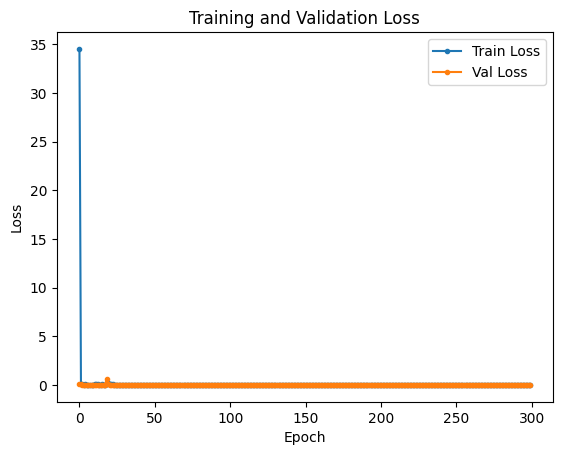

In [9]:
x = list(range(NUM_EPOCHS))
plt.plot(x, train_loss_list, label="Train Loss", marker=".")
plt.plot(x, val_loss_list, label="Val Loss", marker=".")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

## Step 4 - Save / load the model

After training, we need to save the models.

In [10]:
# Save the trained model to disk
torch.save(vgg16.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to ./models/VGG16_epoch_300_batch_size_256_lr_1e-03_seed_42.pth


To read the saved data, we can run the following codes:

In [11]:
# # Load the trained model weights
# vgg16.load_state_dict(torch.load(MODEL_PATH, map_location=device))
# vgg16.eval()
# print("Model loaded from", MODEL_PATH)

## Exceptional test

Let's see if the model works well.

Model loaded from ./models/VGG16_epoch_300_batch_size_256_lr_1e-03_seed_42.pth


      Real Labels  Predicted Labels      Diff      MAPE
0           1.746          1.791037  0.045037  0.974206
1           2.695          2.851461  0.156461  0.941944
2           1.816          2.132442  0.316442  0.825748
3           2.354          2.513246  0.159246  0.932351
4           3.901          3.755784 -0.145216  0.962775
...           ...               ...       ...       ...
1834        2.051          1.749637 -0.301363  0.853065
1835        1.757          1.622897 -0.134103  0.923675
1836        2.593          2.962396  0.369396  0.857541
1837        4.092          3.886216 -0.205784  0.949711
1838        2.040          1.682422 -0.357578  0.824716

[1839 rows x 4 columns]
MAPE: 0.9310271954956364


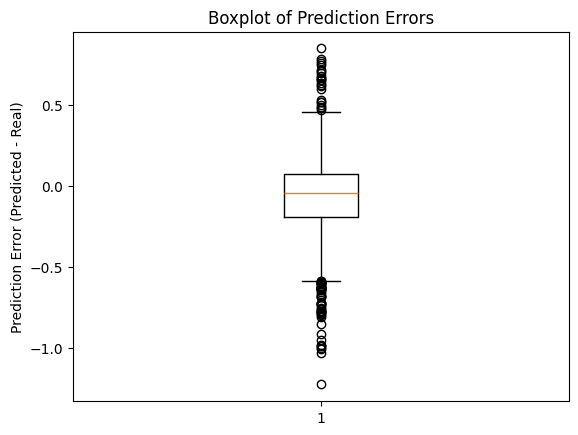

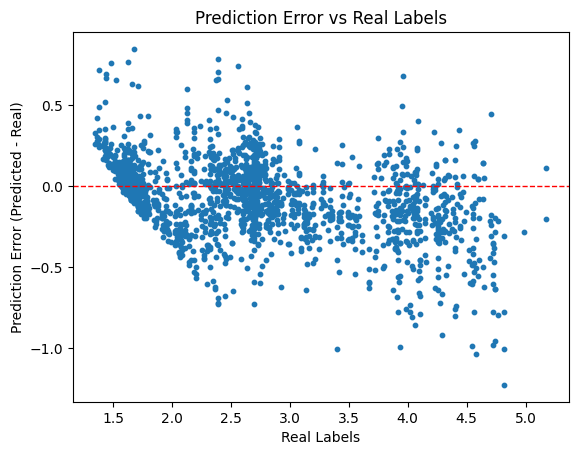

In [12]:
# Load the trained model weights
vgg16.load_state_dict(torch.load(MODEL_PATH, map_location=device))
vgg16.eval()
print("Model loaded from", MODEL_PATH)

# Turn to `numpy.array`
labels_val_real = labels_val.numpy()
labels_val_predicted = vgg16(images_val_tensor.to(device)).cpu().detach().numpy()

# Unnormalize labels
labels_val_real = labels_val_real * (MAX_LABEL - MIN_LABEL) + MIN_LABEL
labels_val_predicted = labels_val_predicted * (MAX_LABEL - MIN_LABEL) + MIN_LABEL

# Turn to `pandas.Series`
labels_val_real = pd.Series(labels_val_real)
labels_val_predicted = pd.Series(labels_val_predicted.flatten())
labels_val_diff = labels_val_predicted - labels_val_real

# Make `pandas.DataFrame`
df = pd.DataFrame(
    {
        "Real Labels": labels_val_real,
        "Predicted Labels": labels_val_predicted,
        "Diff": labels_val_diff,
        "MAPE": 1 - np.abs(labels_val_diff) / labels_val_real
    }
)
df.to_csv(OUTPUT_PATH, index = False)
print(df)
print(f"MAPE: {df["MAPE"].mean()}")

# Boxplot of the differences
plt.boxplot(labels_val_diff)
plt.ylabel("Prediction Error (Predicted - Real)")
plt.title("Boxplot of Prediction Errors")
plt.show()

# Plot the differences by the real labels.
plt.scatter(labels_val_real, labels_val_diff, s=10)
plt.xlabel("Real Labels")
plt.ylabel("Prediction Error (Predicted - Real)")
plt.title("Prediction Error vs Real Labels")
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.show()